# Classifiying the Iris Dataset using Multinomial Logistic Regression



## Problem

The Iris dataset contains four phenotypic measurements from three different species of iris. The challenge is to predict the species of a flower from the four measurements.

We are given $X_i \in \mathcal{X} \subset \mathbb{R}^4$ and $Y_i \in \mathcal{Y} = \{0, 1, 2\}$. The total number of samples is 150 and the classes are balanced. For prediction, I will use a multonmial logistic regression (a multiclass extension of binary logistic regression). 

In [1]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
%matplotlib inline

## Data

In [2]:
# Load the iris data set
iris = load_iris()

# Wrangle the data into a Pandas DataFrame
feature_names = iris["feature_names"]
df = pd.DataFrame(iris["data"], columns=feature_names)
df["species"] = iris["target"]
df["species"] = df["species"].apply(lambda x: iris["target_names"][x])

# Visualize the dataframe and look at the dimension of the data
print(df.shape)
df.head()

(150, 5)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


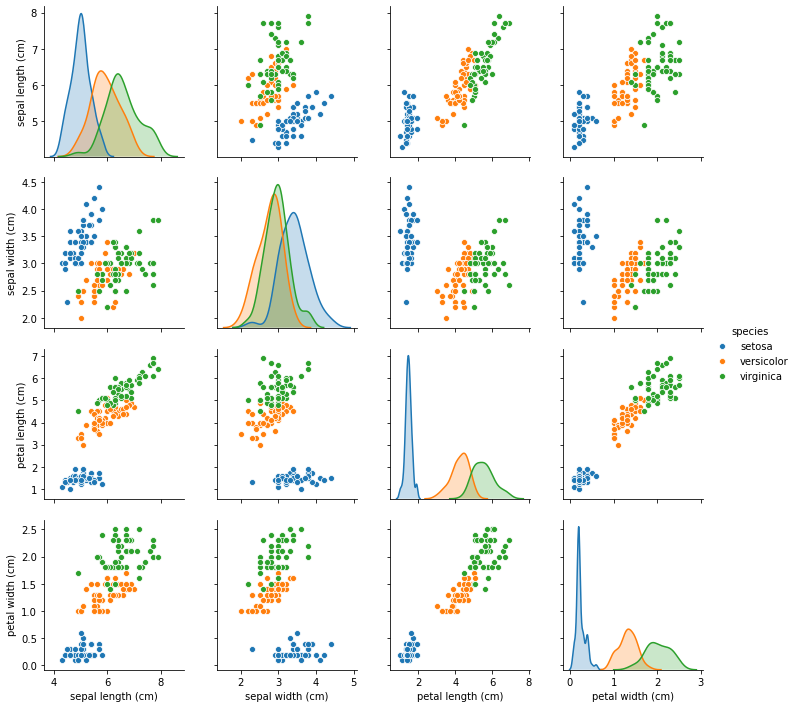

In [3]:
# Plot a pairplot of the data with class labels
g = sns.pairplot(data=df, hue="species")
plt.savefig("pairs")
plt.show()

## Model fitting

- I am fitting a multinomial logistic regression
- To avoid overfitting, I am splitting the data into a training and testing set and reporting both accuracies seperately. Since the clusters look fairly linearly seperable, I will train the classifier on only 10% of the data.
- To evaluate the performance of the model, I will report the classification accuracy of the testing set and the Area Under the ROC Curve (AUROC) for each of the leave-one-out classifiers.

In [4]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    df[feature_names],
    df["species"],
    test_size=0.90,
    random_state=42,
    stratify=df["species"],
)

In [50]:
# Fit a logistic classifier
clf = LogisticRegression(
    solver="sag",
    max_iter=100,
    random_state=0,
    multi_class="multinomial",
).fit(X_train, y_train)

# Predict the labels of the testing set
y_score = clf.predict(X_test)

# What weights has the classifier learned?
print(clf.coef_)
print(clf.intercept_)

[[ 0.2660623   0.68677395 -1.13992726 -0.48470934]
 [ 0.11429764 -0.0727098   0.07666636 -0.11054872]
 [-0.38035994 -0.61406414  1.0632609   0.59525806]]
[ 0.72395208  0.19623416 -0.92018624]


In [6]:
def binarize(species, y_score, y_test):
    
    y_test = y_test.values
    return (y_score == species), (y_test == species)

In [7]:
# Compute ROC curve and AUROC for each class
auroc = dict()
for species in clf.classes_:
    fpr, tpr, _ = roc_curve(*binarize(species, y_score, y_test))
    auroc[species] = auc(fpr, tpr)
    
print(auroc)

{'setosa': 1.0, 'versicolor': 0.96875, 'virginica': 0.9411764705882353}


In [8]:
# Measure testing set classification accuracy
test_acc = clf.score(X_test, y_test)
print("Testing set classification accuracy : {0:.3f}".format(test_acc))

Testing set classification accuracy : 0.956


## Plot the decision boundary

- To further demonstrate that this model is not overfitting, I plot the decision boundary for a pair of features. The boundary is simple.

In [13]:
class DecisionBoundary:
    
    """
    Class to handle the calculation and plotting of the decision boundary learned by the classifier.
    """
    
    def __init__(self, df, feature_names, clf):
        self.df = df
        self.feature_names = feature_names
        self.clf = clf

    def transform(self, h=0.2, delta=0.5):
        
        # Create a meshgrid for feature space
        X = self.df[self.feature_names]
        x_min = X.min().values - delta
        x_max = X.max().values + delta
        ranges = [np.arange(xi_min, xi_max, h) for xi_min, xi_max in zip(x_min, x_max)]
        xx, yy, zz, ww = np.meshgrid(*ranges)
        contour = np.c_[[arr.ravel() for arr in [xx, yy, zz, ww]]].T
        shape = (xx.shape[0]*xx.shape[1], xx.shape[2]*xx.shape[3])
    
        # Predict the label at each point
        Z = clf.predict(contour)
        _, Z = np.unique(Z, return_inverse=True)
    
        # Convert meshgrid and predictions to a dataframe
        predictions = pd.DataFrame(contour, columns=feature_names)
        predictions["class"] = Z
    
        return predictions, shape
    
    def plot(self, xi, xj, predictions, shape, X_test, y_test, colors="yrb"):
        
        fig, ax = plt.subplots()
        
        # Plot the decision boundaries
        xx = predictions[xi].values.reshape(shape)
        yy = predictions[xj].values.reshape(shape)
        zz = predictions["class"].values.reshape(shape)
        ax.pcolormesh(xx, yy, zz)
        ax.set(xlabel=xi, ylabel=xj)
        
        # Plot the testing point
        for label, color in zip(self.clf.classes_, colors):
            idx = np.where(y_test == label)
            ax.scatter(X_test.iloc[idx][xi], X_test.iloc[idx][xj], c=color, cmap=plt.cm.Paired, edgecolor='black', s=20)
        
        plt.tight_layout()
        return fig

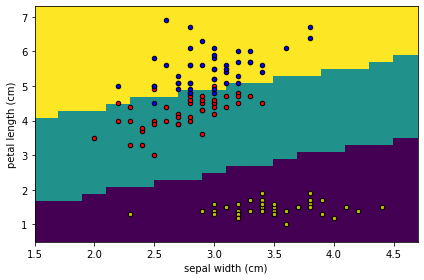

In [14]:
db = DecisionBoundary(df, feature_names, clf)
predictions, shape = db.transform()
fig = db.plot("sepal width (cm)", "petal length (cm)", predictions, shape, X_test, y_test)
plt.savefig("decision")
plt.show()